# Full Pipeline Tutorial

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tlancaster6/AquaCal/blob/main/docs/tutorials/01_full_pipeline.ipynb)

This tutorial demonstrates the complete AquaCal calibration pipeline from start to finish. You'll learn how to:

- Load synthetic or real calibration data
- Run all four calibration stages (or load a previous calibration)
- Visualize camera rig geometry and calibration quality
- Diagnose calibration results with reprojection and 3D error analysis

**Prerequisites:** Basic Python and OpenCV knowledge. Familiarity with camera calibration concepts is helpful but not required.

## Data Source Selection

Choose your data source:

- **`synthetic-1`** (recommended for first run): Uses a bundled small dataset (2 cameras, 10 frames). Fast, no download required.
- **`synthetic-2`**: Generates a realistic synthetic rig on-the-fly (6 cameras, 80 frames, 0.5 px noise). Slower but produces compelling diagnostics.
- **`zenodo`**: Downloads a real hardware dataset from Zenodo (~164 MB, 9+ cameras). Loads a reference calibration result for inspection. Requires internet on first run.

In [1]:
DATA_SOURCE = "synthetic-2"  # Options: "synthetic-1", "synthetic-2", "zenodo" 

## Setup and Imports

We'll import the necessary modules and configure matplotlib for inline plotting.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from aquacal.calibration import calibrate_from_detections
from aquacal.core.board import BoardGeometry
from aquacal.datasets import (
    generate_synthetic_detections,
    generate_synthetic_rig,
    load_example,
)
from aquacal.io.serialization import load_calibration
from aquacal.validation.diagnostics import plot_camera_rig, plot_per_camera_error, plot_error_distribution
from aquacal.validation.reprojection import compute_reprojection_errors

# Configure matplotlib
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 10

print("Imports complete!")

Imports complete!


## Load Data and Calibrate

This cell loads data and produces a `CalibrationResult` — the central object for all
subsequent analysis. The path differs by data source:

- **Synthetic**: generate a scenario, produce detections, run Stages 2-3
- **Zenodo (real rig)**: download the dataset and load a reference calibration

In [3]:
# These will be set by the data-source branch below:
#   result     — CalibrationResult (always)
#   scenario   — SyntheticScenario with ground truth (synthetic only, else None)
#   detections — DetectionResult (synthetic only, else None)
#   board      — BoardGeometry (always)

scenario = None
detections = None
board_poses = None
reprojection_result = None

if DATA_SOURCE in ("synthetic-1", "synthetic-2"):
    # --- Load or generate scenario ---
    if DATA_SOURCE == "synthetic-1":
        dataset = load_example("small")
        scenario = dataset.ground_truth
        print(f"Loaded preset: {dataset.name}")
    else:
        scenario = generate_synthetic_rig("medium", noisy=True)
        print(f"Generated scenario: {scenario.name}")

    print(f"  Cameras: {len(scenario.intrinsics)}, Frames: {len(scenario.board_poses)}, Noise: {scenario.noise_std} px")

    board = BoardGeometry(scenario.board_config)

    # --- Generate detections ---
    print("Generating synthetic detections...")
    detections = generate_synthetic_detections(
        intrinsics=scenario.intrinsics,
        extrinsics=scenario.extrinsics,
        water_zs=scenario.water_zs,
        board=board,
        board_poses=scenario.board_poses,
        noise_std=scenario.noise_std,
        seed=42,
    )

    # --- Run Stages 2-3 ---
    print("Running calibration (Stages 2-3)...")
    result, board_poses = calibrate_from_detections(
        detections, scenario.intrinsics, board,
    )

    # Compute detailed reprojection errors for later analysis
    reprojection_result = compute_reprojection_errors(result, detections, board_poses)
    print(f"\nCalibration complete!  RMS: {result.diagnostics.reprojection_error_rms:.3f} px")

elif DATA_SOURCE == "zenodo":
    print("Downloading real-rig dataset from Zenodo (first run only)...")
    dataset = load_example("real-rig")
    ref_path = dataset.cache_path / "reference_calibration.json"

    if not ref_path.exists():
        print("No reference calibration found. Running full pipeline (this will take a while)...")
        from aquacal.calibration.pipeline import run_calibration
        config_path = dataset.cache_path / "config.yaml"
        result = run_calibration(str(config_path), verbose=True)
    else:
        print(f"Loading reference calibration from {ref_path.name}...")
        result = load_calibration(ref_path)

    board = BoardGeometry(result.board)
    print(f"  Cameras: {len(result.cameras)}")
    print(f"  RMS: {result.diagnostics.reprojection_error_rms:.3f} px")
    print(f"  3D error: {result.diagnostics.validation_3d_error_mean * 1000:.2f} mm (mean)")

else:
    raise ValueError(f"Unknown DATA_SOURCE: {DATA_SOURCE!r}")

Generated scenario: medium
  Cameras: 6, Frames: 80, Noise: 0.5 px
Generating synthetic detections...
Running calibration (Stages 2-3)...

Calibration complete!  RMS: 0.687 px


## Exploring the Result

Every calibration produces a `CalibrationResult` containing per-camera parameters,
interface geometry, and diagnostic metrics.

In [4]:
cam_names_sorted = sorted(result.cameras.keys())
print(f"Cameras ({len(cam_names_sorted)}): {cam_names_sorted}")

print(f"\nBoard: {result.board.squares_x}x{result.board.squares_y}, "
      f"{result.board.square_size * 1000:.1f} mm squares")

print(f"\nInterface: n_air={result.interface.n_air}, n_water={result.interface.n_water}")

print(f"\nDiagnostics:")
print(f"  Reprojection RMS: {result.diagnostics.reprojection_error_rms:.3f} px")
if result.diagnostics.validation_3d_error_mean > 0:
    print(f"  3D error mean:    {result.diagnostics.validation_3d_error_mean * 1000:.2f} mm")
    print(f"  3D error std:     {result.diagnostics.validation_3d_error_std * 1000:.2f} mm")

print(f"\nWater surface Z per camera:")
for cam in cam_names_sorted:
    cc = result.cameras[cam]
    C = cc.extrinsics.C
    h_c = cc.water_z - C[2]
    print(f"  {cam}: water_z = {cc.water_z:.4f} m, "
          f"C = [{C[0]:.3f}, {C[1]:.3f}, {C[2]:.3f}], h_c = {h_c:.4f} m")

Cameras (6): ['cam0', 'cam1', 'cam2', 'cam3', 'cam4', 'cam5']

Board: 12x9, 60.0 mm squares

Interface: n_air=1.0, n_water=1.333

Diagnostics:
  Reprojection RMS: 0.687 px

Water surface Z per camera:
  cam0: water_z = 0.1505 m, C = [0.000, 0.000, 0.000], h_c = 0.1505 m
  cam1: water_z = 0.1505 m, C = [0.120, 0.000, 0.001], h_c = 0.1500 m
  cam2: water_z = 0.1505 m, C = [0.240, -0.000, -0.000], h_c = 0.1508 m
  cam3: water_z = 0.1505 m, C = [-0.000, 0.120, -0.001], h_c = 0.1514 m
  cam4: water_z = 0.1505 m, C = [0.120, 0.120, -0.001], h_c = 0.1513 m
  cam5: water_z = 0.1505 m, C = [0.240, 0.120, 0.000], h_c = 0.1501 m


## Camera Rig Geometry

A 3D plot of the camera positions and orientations from the calibration result.
The water surface plane is shown at the estimated Z-coordinate.

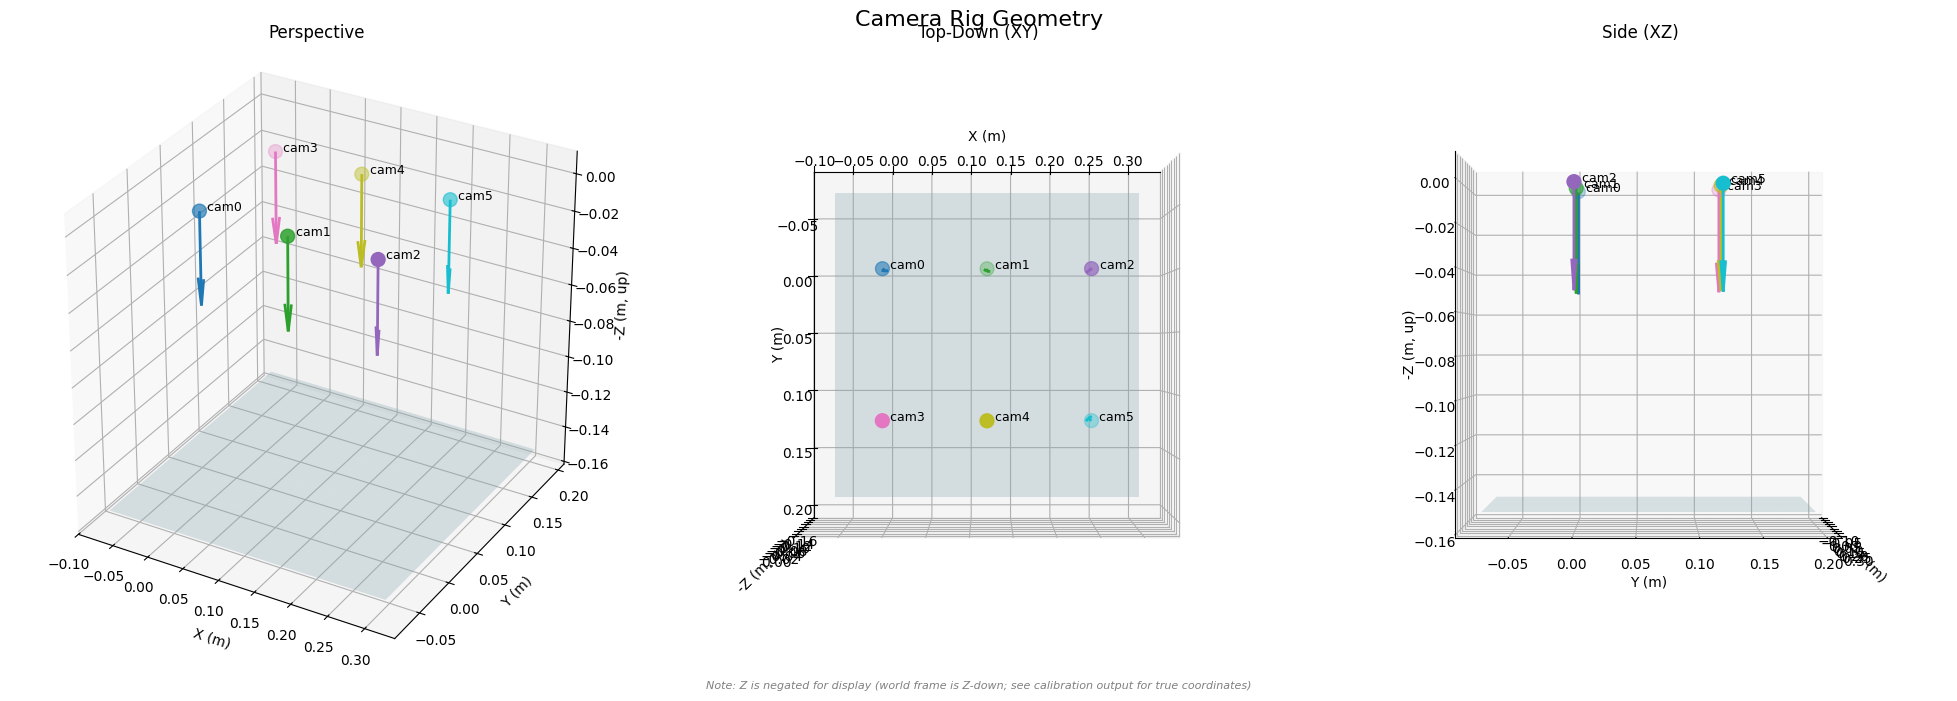

In [5]:
fig = plot_camera_rig(result, title="Camera Rig Geometry")
plt.show()
plt.close()

## Intrinsic Parameters

Focal lengths and principal points for each camera. For synthetic data these are
ground truth values passed through to calibration; for real data they come from
Stage 1 (in-air) calibration.

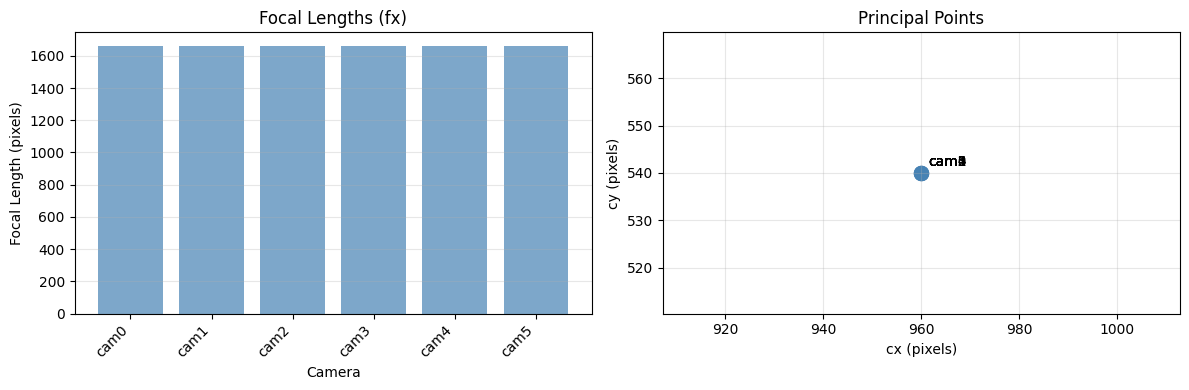

In [6]:
def plot_intrinsics_summary(result):
    """Side-by-side focal length bar chart and principal point scatter."""
    cam_names = sorted(result.cameras.keys())
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    fx_vals = [result.cameras[c].intrinsics.K[0, 0] for c in cam_names]
    cx_vals = [result.cameras[c].intrinsics.K[0, 2] for c in cam_names]
    cy_vals = [result.cameras[c].intrinsics.K[1, 2] for c in cam_names]

    x = np.arange(len(cam_names))
    ax1.bar(x, fx_vals, color='steelblue', alpha=0.7)
    ax1.set_xlabel('Camera')
    ax1.set_ylabel('Focal Length (pixels)')
    ax1.set_title('Focal Lengths (fx)')
    ax1.set_xticks(x)
    ax1.set_xticklabels(cam_names, rotation=45, ha='right')
    ax1.grid(axis='y', alpha=0.3)

    ax2.scatter(cx_vals, cy_vals, s=100, color='steelblue', alpha=0.7)
    for i, cam in enumerate(cam_names):
        ax2.annotate(cam, (cx_vals[i], cy_vals[i]), xytext=(5, 5), textcoords='offset points')
    ax2.set_xlabel('cx (pixels)')
    ax2.set_ylabel('cy (pixels)')
    ax2.set_title('Principal Points')
    ax2.grid(alpha=0.3)

    fig.tight_layout()
    return fig

fig = plot_intrinsics_summary(result)
plt.show()
plt.close()

## Diagnostics

### Per-Camera Reprojection Error

A bar chart of per-camera RMS errors quickly reveals whether any camera is performing
worse than the others. Cameras with high error often have poor intrinsic calibration
or insufficient board observations.

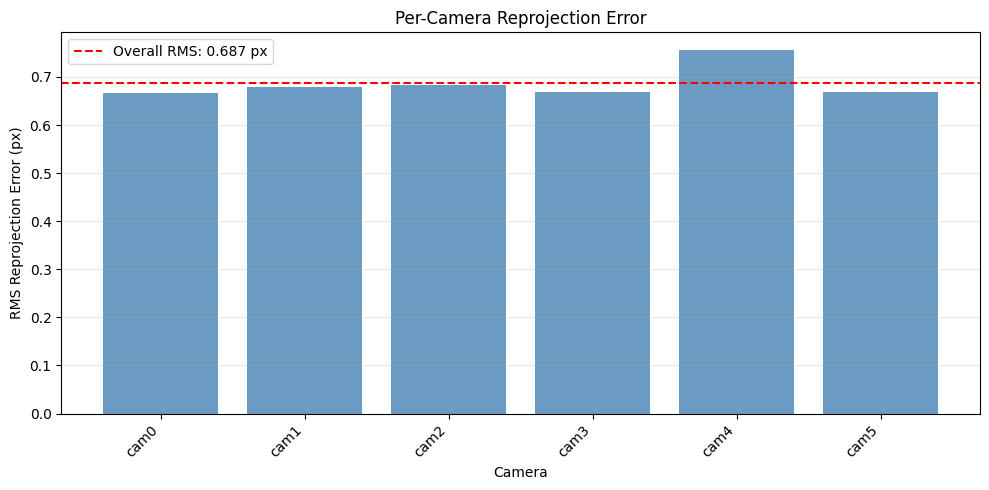

Cameras with error > 2x the average may need re-calibration.


In [7]:
fig = plot_per_camera_error(result)
plt.show()
plt.close()

print("Cameras with error > 2x the average may need re-calibration.")

### Reprojection Error Distribution

The histogram shows the overall distribution of per-corner errors across all cameras
and frames. A well-calibrated rig produces a tight distribution centered near zero.

> This plot requires raw detections and is only available for synthetic data sources.

Error statistics:
  Mean:            0.603 px
  Median:          0.565 px
  95th percentile: 1.203 px
  Max:             2.193 px


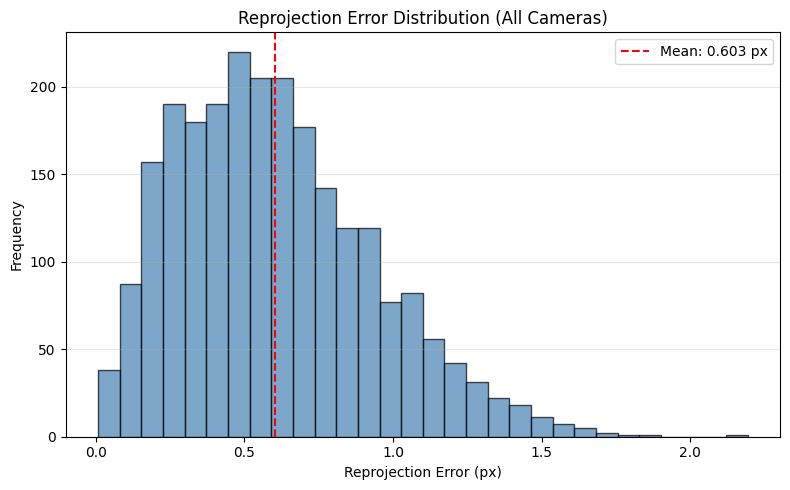

In [8]:
if reprojection_result is not None:
    fig = plot_error_distribution(reprojection_result)
    plt.show()
    plt.close()
else:
    print("Skipped — raw detections not available for this data source.")
    print(f"Overall RMS from calibration: {result.diagnostics.reprojection_error_rms:.3f} px")

### Interface Distance Recovery (Synthetic Only)

The water surface Z-coordinate (`water_z`) is the key refractive parameter.
Comparing estimated values to ground truth tells you how well Stage 3 converged.

Mean absolute interface distance error: 1.67 mm


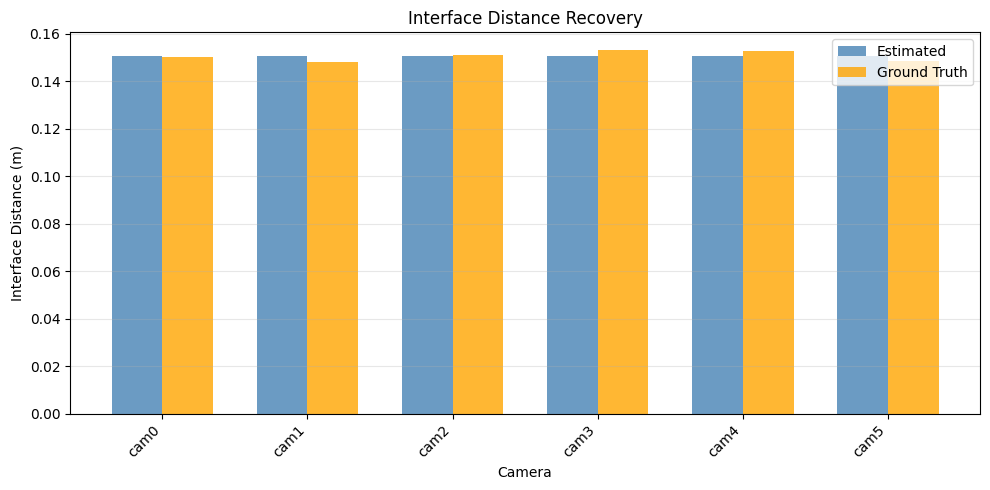

In [9]:
def plot_interface_recovery(result, scenario):
    """Grouped bar chart comparing estimated vs ground-truth water_z."""
    cam_names = sorted(result.cameras.keys())
    estimated = [result.cameras[c].water_z for c in cam_names]
    ground_truth = [scenario.water_zs[c] for c in cam_names]

    fig, ax = plt.subplots(figsize=(10, 5))
    x = np.arange(len(cam_names))
    width = 0.35

    ax.bar(x - width / 2, estimated, width, label='Estimated', color='steelblue', alpha=0.8)
    ax.bar(x + width / 2, ground_truth, width, label='Ground Truth', color='orange', alpha=0.8)

    ax.set_xlabel('Camera')
    ax.set_ylabel('Interface Distance (m)')
    ax.set_title('Interface Distance Recovery')
    ax.set_xticks(x)
    ax.set_xticklabels(cam_names, rotation=45, ha='right')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    fig.tight_layout()

    mean_err = np.mean([abs(e - g) for e, g in zip(estimated, ground_truth)])
    print(f"Mean absolute interface distance error: {mean_err * 1000:.2f} mm")
    return fig

if scenario is not None:
    fig = plot_interface_recovery(result, scenario)
    plt.show()
    plt.close()
else:
    print("Skipped — ground truth not available for real data.")
    print("Estimated water_z values are shown in the result summary above.")

### 3D Reconstruction Error

Reprojection error measures 2D fit quality, but 3D reconstruction error is the ultimate
accuracy metric. We triangulate board corners from multiple cameras and compare the
recovered inter-corner distances to the known board geometry.

3D Reconstruction Quality:
  Signed mean error: 0.002 mm
  RMSE:              0.156 mm
  Comparisons:       1041


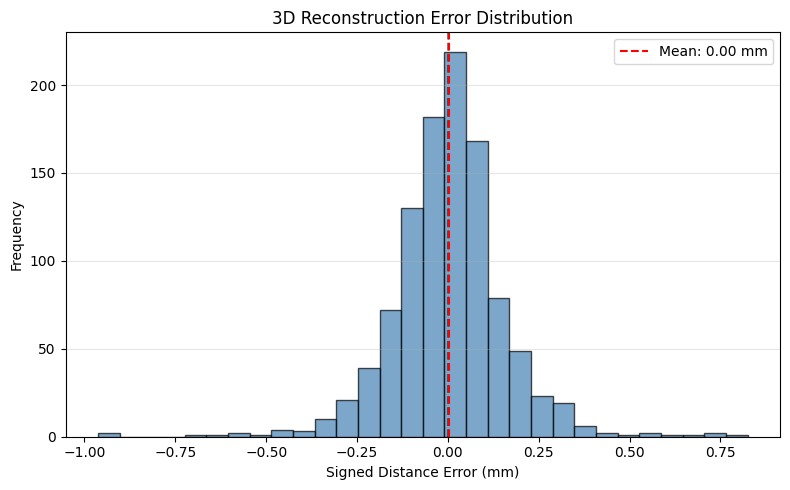

In [10]:
if detections is not None:
    from aquacal.validation.reconstruction import compute_3d_distance_errors

    dist_errors = compute_3d_distance_errors(
        calibration=result,
        detections=detections,
        board=board,
        include_per_pair=False,
        include_spatial=True,
    )

    print("3D Reconstruction Quality:")
    print(f"  Signed mean error: {dist_errors.signed_mean * 1000:.3f} mm")
    print(f"  RMSE:              {dist_errors.rmse * 1000:.3f} mm")
    print(f"  Comparisons:       {dist_errors.num_comparisons}")

    if dist_errors.spatial is not None:
        fig, ax = plt.subplots(figsize=(8, 5))
        ax.hist(
            dist_errors.spatial.signed_errors * 1000,
            bins=30, color='steelblue', alpha=0.7, edgecolor='black',
        )
        ax.axvline(0, color='black', linestyle='--', alpha=0.5)
        ax.axvline(
            dist_errors.signed_mean * 1000, color='red', linestyle='--',
            label=f'Mean: {dist_errors.signed_mean * 1000:.2f} mm',
        )
        ax.set_xlabel('Signed Distance Error (mm)')
        ax.set_ylabel('Frequency')
        ax.set_title('3D Reconstruction Error Distribution')
        ax.legend()
        ax.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()
        plt.close()
else:
    print("3D Reconstruction Quality (from reference calibration):")
    print(f"  Mean error: {result.diagnostics.validation_3d_error_mean * 1000:.2f} mm")
    print(f"  Std:        {result.diagnostics.validation_3d_error_std * 1000:.2f} mm")

### Common Issues Checklist

| Symptom | Likely Cause | Fix |
|---------|-------------|-----|
| High error for one camera | Poor intrinsic calibration | Re-calibrate intrinsics with more frames, check for motion blur |
| High error in image corners | Distortion model insufficient | Try rational model (8 coefficients) |
| Interface distance not converging | Initial estimate too far from truth | Provide better `initial_water_zs` in config |
| Interface distances differ between cameras | Degenerate board poses | Ensure board is visible at varied angles and depths |
| High 3D reconstruction error | Systematic bias | Check that `n_water` is correct for your water type |
| Reprojection < 1px but 3D error high | Overfitting to 2D | Verify interface distance initialization, add validation frames |

## Stage 4: Optional Intrinsic Refinement

Stage 4 optionally refines per-camera focal lengths (fx, fy) and principal points
(cx, cy) alongside extrinsics and interface distances.

**When to enable:** Only after Stage 3 converges reliably. Distortion coefficients
are NOT refined.

For synthetic data with known-good intrinsics, this stage provides minimal benefit.
For real hardware, it often improves results by 5-15%.

In [11]:
print("Stage 4 is optional and disabled by default.")
print("Enable with refine_intrinsics=True in CalibrationConfig.")
print("Recommended for real hardware where intrinsics may have residual errors.")

Stage 4 is optional and disabled by default.
Enable with refine_intrinsics=True in CalibrationConfig.
Recommended for real hardware where intrinsics may have residual errors.


## Saving and Loading Results

AquaCal provides utilities to save and load calibration results in JSON format.

In [12]:
# Save calibration result
# save_calibration(result, "output/calibration.json")

# Load it back later
# loaded = load_calibration("output/calibration.json")

print("Calibration results can be saved to JSON for later use.")
print("See aquacal.io.serialization.save_calibration() and load_calibration().")

Calibration results can be saved to JSON for later use.
See aquacal.io.serialization.save_calibration() and load_calibration().


## Summary

In this tutorial you learned how to:

1. Load calibration data (synthetic or real hardware from Zenodo)
2. Run the calibration pipeline (Stages 2-3) or load a reference calibration
3. Inspect camera rig geometry, intrinsic parameters, and interface distances
4. Diagnose calibration quality with per-camera, distribution, and 3D error analysis
5. Save and load calibration results

**Next:** Explore [why refractive calibration matters](02_synthetic_validation.ipynb) with
controlled experiments comparing refractive vs non-refractive models.

- [User Guide](../guide/index.md): Comprehensive documentation on calibration theory and best practices